<a href="https://colab.research.google.com/github/paulomarc49/ETo_climate/blob/main/ETo_climate_training_prediction_reproducibility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. ETo climate training:

## 1.1. Generation of the mesh of pixels coordinates and dates

In [ ]:
# Installing sklearn-som package.
!pip install sklearn-som

# Import libraries, if needed run: !pip install gdown.
import joblib
import numpy              as np
import pandas             as pd
import altair             as alt
import matplotlib.pyplot  as plt
import os
import gdown
from   tqdm                   import tqdm
from   sklearn.preprocessing  import StandardScaler
from   sklearn.base           import BaseEstimator, ClusterMixin
from   sklearn.preprocessing  import MinMaxScaler
from   sklearn_som.som        import SOM as SklearnSOM


# Define days in each month for each year.
year_2017 = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
year_2018 = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
year_2019 = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
year_2020 = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
year_2021 = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
year_2022 = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
pixels_y = np.arange(171)  # generate an array from 0 to 170, which means pixels in x-axis
pixels_x = np.arange(171)  # generate an array from 0 to 170, which menas pixels in y-axis

# Function to generate the pixels_y and pixels_x mesh for each year:
def array_per_year(year, year_number):
    results = []
    for month, days in enumerate(year, 1):
        for day in range(1, days + 1):
            py, px        = np.meshgrid(pixels_y, pixels_x, indexing='ij')
            month_actual  = np.full(px.shape, month)
            day_actual    = np.full(px.shape, day)
            combination   = np.column_stack((py.ravel(), px.ravel(), month_actual.ravel(), day_actual.ravel()))
            results.append(combination)
    return np.vstack(results)

In [ ]:
# Output paths for the data files.
output_paths_dates = {
    2017: '/content/ETo_climate_2017_dates.npy',
    2018: '/content/ETo_climate_2018_dates.npy',
    2019: '/content/ETo_climate_2019_dates.npy',
    2020: '/content/ETo_climate_2020_dates.npy',
    2021: '/content/ETo_climate_2021_dates.npy',
    2022: '/content/ETo_climate_2022_dates.npy'
}

# List of years and corresponding data.
years_data = {
    2017: year_2017,
    2018: year_2018,
    2019: year_2019,
    2020: year_2020,
    2021: year_2021,
    2022: year_2022
}

# Generate arrays and save them if the file does not exist.
for year, year_days in years_data.items():
    outpath = output_paths_dates[year]
    if not os.path.exists(outpath):
        # Generate the array for the year and save it.
        results = array_per_year(year_days, year)
        np.save(outpath, results, allow_pickle=False)
        print(f'Array for {year} saved to {outpath}')
        print(f"Date time data shape for {year}: {results.shape}")
    else:
        print(f'File for {year} already exists at {outpath}, skipping array generation.')

Array for 2017 saved to /content/ETo_climate_2017_dates.npy
Date time data shape for 2017: (10672965, 4)
Array for 2018 saved to /content/ETo_climate_2018_dates.npy
Date time data shape for 2018: (10672965, 4)
Array for 2019 saved to /content/ETo_climate_2019_dates.npy
Date time data shape for 2019: (10672965, 4)
Array for 2020 saved to /content/ETo_climate_2020_dates.npy
Date time data shape for 2020: (10702206, 4)
Array for 2021 saved to /content/ETo_climate_2021_dates.npy
Date time data shape for 2021: (10672965, 4)
Array for 2022 saved to /content/ETo_climate_2022_dates.npy
Date time data shape for 2022: (10672965, 4)


In [ ]:
# Example of mesh of pixels and dates for year 2017:
# 171 pixels in y * 171 pixels in x * 365 days = 10 672 965 registers

ETo_climate_dates  = np.load('/content/ETo_climate_2017_dates.npy')
ETo_climate_2017_train_pd = pd.DataFrame(ETo_climate_dates, columns=['pixel_y', 'pixel_x', 'Month', 'Day'])
ETo_climate_2017_train_pd

,pixel_y,pixel_x,Month,Day
0,0,0,1,1
1,0,1,1,1
2,0,2,1,1
3,0,3,1,1
4,0,4,1,1
...,...,...,...,...
10672960,170,166,12,31
10672961,170,167,12,31
10672962,170,168,12,31
10672963,170,169,12,31


## 1.2. Concatenation of mesh of pixels coordinates and dates with ETo weather clusters

In [ ]:
file_id_2017      = '1dflY1oOVLRyZYzKpYGmcuxLYNU9x_K_z'
file_id_2018      = '1-4s8M1K0thJ8RGxrIGkQNR5om_5r05Je'
file_id_2019      = '1-8qn_5E_C5Q90zUEZKJvG7A559_o8lrF'
file_id_2020      = '1-BLtquk0_RTJCNy8WzoViUFF23-J6gdx'
file_id_2021_2022 = '1-5xq2TbtCqURWI6kMgAuJJTB1gdZlSW7'

gdown.download(f'https://drive.google.com/uc?id={file_id_2017}'      , '2017_ETo_weather_labels_v2.npy'     , quiet=False)
gdown.download(f'https://drive.google.com/uc?id={file_id_2018}'      , '2018_ETo_weather_labels_v2.npy'     , quiet=False)
gdown.download(f'https://drive.google.com/uc?id={file_id_2019}'      , '2019_ETo_weather_labels_v2.npy'     , quiet=False)
gdown.download(f'https://drive.google.com/uc?id={file_id_2020}'      , '2020_ETo_weather_labels_v2.npy'     , quiet=False)
gdown.download(f'https://drive.google.com/uc?id={file_id_2021_2022}' , '2021_2022_ETo_weather_labels_v2.npy', quiet=False)

# Split 2021 and 2022 ETo weather labels in individual years.
ETo_weather_labels_2021_2022 = np.load('/content/2021_2022_ETo_weather_labels_v2.npy')
ETo_weather_labels_2021 = ETo_weather_labels_2021_2022[:10672965]
ETo_weather_labels_2022 = ETo_weather_labels_2021_2022[10672965:]
np.save('/content/2021_ETo_weather_labels_v2.npy', ETo_weather_labels_2021)
np.save('/content/2022_ETo_weather_labels_v2.npy', ETo_weather_labels_2022)

# Input paths of ETo weather labels for histogram construction.
paths_ETo_weather_labels_train = {
    2017: '/content/2017_ETo_weather_labels_v2.npy',
    2018: '/content/2018_ETo_weather_labels_v2.npy',
    2019: '/content/2019_ETo_weather_labels_v2.npy',
    2020: '/content/2020_ETo_weather_labels_v2.npy',
    2021: '/content/2021_ETo_weather_labels_v2.npy',
    2022: '/content/2022_ETo_weather_labels_v2.npy'
}

# Output paths of ETo climate mesh of pixels and date for histogram construction.
output_paths_ETo_climate_train = {
    2017: '/content/2017_ETo_climate_pixel_date_label_mesh.npy',
    2018: '/content/2018_ETo_climate_pixel_date_label_mesh.npy',
    2019: '/content/2019_ETo_climate_pixel_date_label_mesh.npy',
    2020: '/content/2020_ETo_climate_pixel_date_label_mesh.npy',
    2021: '/content/2021_ETo_climate_pixel_date_label_mesh.npy',
    2022: '/content/2022_ETo_climate_pixel_date_label_mesh.npy'
}

# Generate arrays and save them if the file does not exist
for year, path in paths_ETo_weather_labels_train.items():
    outpath = output_paths_ETo_climate_train[year]
    datepath = output_paths_dates[year]
    if not os.path.exists(outpath):
        ETo_weather_labels = np.load(path)
        print(f'The {year} ETo weather labels for histogram construction has the shape:                   {ETo_weather_labels.shape}')
        ETo_climate_pixel_date_mesh  = np.load(datepath)
        print(f'The {year} ETo climate mesh of pixels and dates for histogram construction has the shape: {ETo_climate_pixel_date_mesh.shape}')
        ETo_climate_pixel_date_label_mesh = np.concatenate((ETo_climate_pixel_date_mesh, ETo_weather_labels.reshape(-1, 1)), axis=1)
        print(f'The {year} ETo climate concatenated array for histogram construction has the shape:       {ETo_climate_pixel_date_label_mesh.shape}')
        np.save(outpath, ETo_climate_pixel_date_label_mesh, allow_pickle=False)
        print(f'Array for {year} saved to {outpath}\n')
    else:
        print(f'File for {year} already exists at {outpath}, skipping array generation.')

Downloading...
From: https://drive.google.com/uc?id=1dflY1oOVLRyZYzKpYGmcuxLYNU9x_K_z
To: /content/2017_ETo_weather_labels_v2.npy
100%|██████████| 21.3M/21.3M [00:00<00:00, 38.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-4s8M1K0thJ8RGxrIGkQNR5om_5r05Je
To: /content/2018_ETo_weather_labels_v2.npy
100%|██████████| 21.3M/21.3M [00:00<00:00, 31.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-8qn_5E_C5Q90zUEZKJvG7A559_o8lrF
To: /content/2019_ETo_weather_labels_v2.npy
100%|██████████| 21.3M/21.3M [00:00<00:00, 53.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-BLtquk0_RTJCNy8WzoViUFF23-J6gdx
To: /content/2020_ETo_weather_labels_v2.npy
100%|██████████| 21.4M/21.4M [00:00<00:00, 66.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-5xq2TbtCqURWI6kMgAuJJTB1gdZlSW7
To: /content/2021_2022_ETo_weather_labels_v2.npy
100%|██████████| 42.7M/42.7M [00:00<00:00, 55.7MB/s]


The 2017 ETo weather labels for histogram construction has the shape:                   (10672965,)
The 2017 ETo climate mesh of pixels and dates for histogram construction has the shape: (10672965, 4)
The 2017 ETo climate concatenated array for histogram construction has the shape:       (10672965, 5)
Array for 2017 saved to /content/2017_ETo_climate_pixel_date_label_mesh.npy

The 2018 ETo weather labels for histogram construction has the shape:                   (10672965,)
The 2018 ETo climate mesh of pixels and dates for histogram construction has the shape: (10672965, 4)
The 2018 ETo climate concatenated array for histogram construction has the shape:       (10672965, 5)
Array for 2018 saved to /content/2018_ETo_climate_pixel_date_label_mesh.npy

The 2019 ETo weather labels for histogram construction has the shape:                   (10672965,)
The 2019 ETo climate mesh of pixels and dates for histogram construction has the shape: (10672965, 4)
The 2019 ETo climate concatenated ar

## 1.3. Histogram generation:

In [ ]:
# Load the numpy array of labels and dates joined.
ETo_climate_pixel_date_label_mesh_2017 = np.load('/content/2017_ETo_climate_pixel_date_label_mesh.npy')
ETo_climate_pixel_date_label_mesh_2018 = np.load('/content/2018_ETo_climate_pixel_date_label_mesh.npy')
ETo_climate_pixel_date_label_mesh_2019 = np.load('/content/2019_ETo_climate_pixel_date_label_mesh.npy')
ETo_climate_pixel_date_label_mesh_2020 = np.load('/content/2020_ETo_climate_pixel_date_label_mesh.npy')
ETo_climate_pixel_date_label_mesh_2021 = np.load('/content/2021_ETo_climate_pixel_date_label_mesh.npy')
ETo_climate_pixel_date_label_mesh_2022 = np.load('/content/2022_ETo_climate_pixel_date_label_mesh.npy')

# Transform from numpy to dataframe for manipulation.
ETo_climate_pixel_date_label_mesh_2017_pd = pd.DataFrame(ETo_climate_pixel_date_label_mesh_2017, columns=['pixel_y', 'pixel_x', 'Month', 'Day', 'ETo_weather_labels'])
ETo_climate_pixel_date_label_mesh_2018_pd = pd.DataFrame(ETo_climate_pixel_date_label_mesh_2018, columns=['pixel_y', 'pixel_x', 'Month', 'Day', 'ETo_weather_labels'])
ETo_climate_pixel_date_label_mesh_2019_pd = pd.DataFrame(ETo_climate_pixel_date_label_mesh_2019, columns=['pixel_y', 'pixel_x', 'Month', 'Day', 'ETo_weather_labels'])
ETo_climate_pixel_date_label_mesh_2020_pd = pd.DataFrame(ETo_climate_pixel_date_label_mesh_2020, columns=['pixel_y', 'pixel_x', 'Month', 'Day', 'ETo_weather_labels'])
ETo_climate_pixel_date_label_mesh_2021_pd = pd.DataFrame(ETo_climate_pixel_date_label_mesh_2021, columns=['pixel_y', 'pixel_x', 'Month', 'Day', 'ETo_weather_labels'])
ETo_climate_pixel_date_label_mesh_2022_pd = pd.DataFrame(ETo_climate_pixel_date_label_mesh_2022, columns=['pixel_y', 'pixel_x', 'Month', 'Day', 'ETo_weather_labels'])

# Input signal interest features cleanning.
ETo_climate_pixel_date_label_mesh_2017_pd = ETo_climate_pixel_date_label_mesh_2017_pd.drop(columns=['Month', 'Day'])
ETo_climate_pixel_date_label_mesh_2018_pd = ETo_climate_pixel_date_label_mesh_2018_pd.drop(columns=['Month', 'Day'])
ETo_climate_pixel_date_label_mesh_2019_pd = ETo_climate_pixel_date_label_mesh_2019_pd.drop(columns=['Month', 'Day'])
ETo_climate_pixel_date_label_mesh_2020_pd = ETo_climate_pixel_date_label_mesh_2020_pd.drop(columns=['Month', 'Day'])
ETo_climate_pixel_date_label_mesh_2021_pd = ETo_climate_pixel_date_label_mesh_2021_pd.drop(columns=['Month', 'Day'])
ETo_climate_pixel_date_label_mesh_2022_pd = ETo_climate_pixel_date_label_mesh_2022_pd.drop(columns=['Month', 'Day'])

# Generation of train dataset for SOM input signal construction:
# Year 2017: 171 pixels in y * 171 pixels in x * 365 days = 10 672 965 registers
# Year 2019: 171 pixels in y * 171 pixels in x * 365 days = 10 672 965 registers
# Total:     171 pixels in y * 171 pixels in x * 730 days = 21 345 930 registers
ETo_climate_pixel_date_label_mesh_all_years_train_pd = pd.concat(
    [ETo_climate_pixel_date_label_mesh_2017_pd,
     ETo_climate_pixel_date_label_mesh_2019_pd], axis=0)

# Generation of validation dataset for SOM input signal construction:
# Year 2018: 171 pixels in y * 171 pixels in x * 365 days = 10 672 965 registers
# Year 2020: 171 pixels in y * 171 pixels in x * 366 days = 10 702 206 registers
# Total:     171 pixels in y * 171 pixels in x * 731 days = 21 375 171 registers
ETo_climate_pixel_date_label_mesh_all_years_validation_pd = pd.concat(
    [ETo_climate_pixel_date_label_mesh_2018_pd,
     ETo_climate_pixel_date_label_mesh_2020_pd], axis=0)

# Generation of test dataset for SOM input signal construction:
# Year 2021: 171 pixels in y * 171 pixels in x * 365 days = 10 672 965 registers
# Year 2022: 171 pixels in y * 171 pixels in x * 365 days = 10 672 965 registers
# Total:     171 pixels in y * 171 pixels in x * 730 days = 21 345 930 registers
ETo_climate_pixel_date_label_mesh_all_years_test_pd = pd.concat(
    [ETo_climate_pixel_date_label_mesh_2021_pd,
     ETo_climate_pixel_date_label_mesh_2022_pd], axis=0)

ETo_climate_pixel_date_label_mesh_all_years_train_pd.reset_index(drop=True, inplace=True)

print(f'Train dataset shape:      {ETo_climate_pixel_date_label_mesh_all_years_train_pd.shape}')
print(f'Validation dataset shape: {ETo_climate_pixel_date_label_mesh_all_years_validation_pd.shape}')
print(f'Test dataset shape:       {ETo_climate_pixel_date_label_mesh_all_years_test_pd.shape}')


Train dataset shape:      (21345930, 3)
Validation dataset shape: (21375171, 3)
Test dataset shape:       (21345930, 3)


## 1.4. SOM input signal construction

In [ ]:
# Group by pixel_y, pixel_x, and ETo_weather_labels, then sum.
ETo_climate_pixel_date_label_mesh_all_years_grouped_train_pd      = ETo_climate_pixel_date_label_mesh_all_years_train_pd.groupby(['pixel_y', 'pixel_x', 'ETo_weather_labels']).size().reset_index(name='Count')
ETo_climate_pixel_date_label_mesh_all_years_grouped_validation_pd = ETo_climate_pixel_date_label_mesh_all_years_validation_pd.groupby(['pixel_y', 'pixel_x', 'ETo_weather_labels']).size().reset_index(name='Count')
ETo_climate_pixel_date_label_mesh_all_years_grouped_test_pd       = ETo_climate_pixel_date_label_mesh_all_years_test_pd.groupby(['pixel_y', 'pixel_x', 'ETo_weather_labels']).size().reset_index(name='Count')

# Pivot to make each unique ETo_weather_labels value a new column.
ETo_climate_SOM_input_signal_train_pd       = ETo_climate_pixel_date_label_mesh_all_years_grouped_train_pd.pivot(index=['pixel_y', 'pixel_x'], columns='ETo_weather_labels', values='Count')
ETo_climate_SOM_input_signal_validation_pd  = ETo_climate_pixel_date_label_mesh_all_years_grouped_validation_pd.pivot(index=['pixel_y', 'pixel_x'], columns='ETo_weather_labels', values='Count')
ETo_climate_SOM_input_signal_test_pd        = ETo_climate_pixel_date_label_mesh_all_years_grouped_test_pd.pivot(index=['pixel_y', 'pixel_x'], columns='ETo_weather_labels', values='Count')

# Fill NaN with 0 (if any cluster did not exist in any year, it will have 0 count).
ETo_climate_SOM_input_signal_train_pd       = ETo_climate_SOM_input_signal_train_pd.fillna(0).reset_index().astype(int)
ETo_climate_SOM_input_signal_validation_pd  = ETo_climate_SOM_input_signal_validation_pd.fillna(0).reset_index().astype(int)
ETo_climate_SOM_input_signal_test_pd        = ETo_climate_SOM_input_signal_test_pd.fillna(0).reset_index().astype(int)

ETo_climate_SOM_input_signal_train_pd

ETo_weather_labels,pixel_y,pixel_x,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,34,35
0,0,0,1,22,44,35,4,0,0,47,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,12,10,7,11,0,41,...,0,0,0,0,0,0,0,0,0,0
2,0,2,1,10,32,18,5,0,0,42,...,0,0,0,0,0,0,0,0,0,0
3,0,3,1,15,46,27,27,7,0,18,...,0,0,0,0,0,0,0,0,0,0
4,0,4,2,21,84,52,56,10,0,9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29236,170,166,4,9,48,113,170,21,0,1,...,0,0,0,3,0,0,0,0,0,0
29237,170,167,4,10,43,111,170,18,0,1,...,0,0,0,2,0,0,0,0,0,0
29238,170,168,4,10,44,108,169,19,0,1,...,0,0,0,2,0,0,0,0,0,0
29239,170,169,4,10,44,118,162,9,0,1,...,0,0,0,2,0,0,0,0,0,0


In [ ]:
ETo_climate_SOM_input_signal_validation_pd

ETo_weather_labels,pixel_y,pixel_x,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,34,35
0,0,0,1,21,51,39,1,0,0,73,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,18,20,0,7,1,70,...,0,0,0,0,0,0,0,0,0,0
2,0,2,1,9,39,30,2,1,0,77,...,0,0,0,0,0,0,0,0,0,0
3,0,3,2,23,52,45,15,11,0,46,...,0,0,0,0,0,0,0,0,0,0
4,0,4,2,46,82,70,54,16,0,15,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29236,170,166,7,11,64,124,123,13,0,0,...,0,0,0,0,0,0,0,0,0,0
29237,170,167,7,10,67,118,120,13,0,0,...,0,0,0,0,0,0,0,0,0,0
29238,170,168,7,10,61,121,121,15,0,0,...,0,0,0,0,0,0,0,0,0,0
29239,170,169,7,9,60,128,120,10,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ETo_climate_SOM_input_signal_test_pd

ETo_weather_labels,pixel_y,pixel_x,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,34,35
0,0,0,0,44,52,16,0,0,0,44,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,16,26,12,0,0,0,66,...,0,0,0,0,0,0,0,0,0,0
2,0,2,0,38,46,10,0,0,0,54,...,0,0,0,0,0,0,0,0,0,0
3,0,3,2,40,70,16,0,0,0,20,...,0,0,0,0,0,0,0,0,0,0
4,0,4,0,44,84,30,10,2,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29236,170,166,4,0,48,130,120,14,4,0,...,0,0,0,0,0,0,0,0,0,0
29237,170,167,2,0,46,122,120,14,2,0,...,0,0,0,0,0,0,0,0,0,0
29238,170,168,2,0,46,126,116,12,2,0,...,0,0,0,0,0,0,0,0,0,0
29239,170,169,2,0,44,126,116,8,2,0,...,0,0,0,0,0,0,0,0,0,0


# 1.5. Normalization

In [ ]:
# Normalization.
scaler = MinMaxScaler()
ETo_climate_SOM_input_signal_train_normalized       = scaler.fit_transform(ETo_climate_SOM_input_signal_train_pd.values)
ETo_climate_SOM_input_signal_validation_normalized  = scaler.transform(ETo_climate_SOM_input_signal_validation_pd.values)
ETo_climate_SOM_input_signal_test_normalized        = scaler.transform(ETo_climate_SOM_input_signal_test_pd.values)

# Convert back to DataFrame
ETo_climate_SOM_input_signal_train_normalized_pd = pd.DataFrame(
    ETo_climate_SOM_input_signal_train_normalized,
    index=ETo_climate_SOM_input_signal_train_pd.index,
    columns=ETo_climate_SOM_input_signal_train_pd.columns
)

ETo_climate_SOM_input_signal_train_normalized_pd.describe()

ETo_weather_labels,pixel_y,pixel_x,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,34,35
count,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,...,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000
mean,0.500000,0.500000,0.032606,0.133013,0.326396,0.338983,0.119451,0.026883,0.018032,0.031066,...,0.010506,0.005838,0.009225,0.007957,0.030714,0.022325,0.011408,0.010558,0.014337,0.014014
std,0.290373,0.290373,0.075789,0.157298,0.263535,0.312400,0.128628,0.093821,0.071060,0.106622,...,0.062897,0.041288,0.057681,0.040427,0.103723,0.101414,0.074900,0.043750,0.062375,0.060161
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.247059,0.247059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.012433,0.076613,0.401869,0.326316,0.091168,0.004144,0.001610,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.752941,0.752941,0.026643,0.193548,0.556075,0.636842,0.205128,0.012431,0.003221,0.008902,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Convert back to DataFrame.
ETo_climate_SOM_input_signal_validation_normalized_pd = pd.DataFrame(
    ETo_climate_SOM_input_signal_validation_normalized,
    index=ETo_climate_SOM_input_signal_validation_pd.index,
    columns=ETo_climate_SOM_input_signal_validation_pd.columns
)

ETo_climate_SOM_input_signal_validation_normalized_pd.describe()

ETo_weather_labels,pixel_y,pixel_x,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,34,35
count,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,...,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000
mean,0.500000,0.500000,0.035866,0.167431,0.404171,0.308569,0.085043,0.024497,0.018303,0.030019,...,0.010853,0.005773,0.009022,0.007426,0.029531,0.021781,0.011027,0.009863,0.015264,0.015889
std,0.290373,0.290373,0.085440,0.184936,0.323078,0.285403,0.097764,0.097956,0.073819,0.101368,...,0.064280,0.041346,0.056890,0.041994,0.097655,0.099166,0.072674,0.040953,0.060791,0.064438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.247059,0.247059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.010657,0.096774,0.528037,0.305263,0.065527,0.002762,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.752941,0.752941,0.026643,0.262097,0.705607,0.573684,0.139601,0.006906,0.001610,0.008902,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.104839,1.037383,0.931579,1.008547,0.988950,1.000000,0.949555,...,1.019011,1.161290,1.042683,0.993569,0.958609,0.984649,0.927536,0.981636,0.970414,1.077882


In [ ]:
# Convert back to DataFrame.
ETo_climate_SOM_input_signal_test_normalized_pd = pd.DataFrame(
    ETo_climate_SOM_input_signal_test_normalized,
    index=ETo_climate_SOM_input_signal_test_pd.index,
    columns=ETo_climate_SOM_input_signal_test_pd.columns
)

ETo_climate_SOM_input_signal_test_normalized_pd.describe()

ETo_weather_labels,pixel_y,pixel_x,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,34,35
count,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,...,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000,29241.000000
mean,0.500000,0.500000,0.027112,0.136434,0.373978,0.295304,0.069798,0.027275,0.022662,0.026475,...,0.009752,0.005137,0.008132,0.007690,0.033268,0.021434,0.009268,0.009111,0.013756,0.016200
std,0.290373,0.290373,0.086143,0.189976,0.302338,0.264133,0.079466,0.108696,0.078083,0.100550,...,0.057632,0.035987,0.052469,0.043897,0.110304,0.097411,0.060367,0.037854,0.052052,0.071589
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.247059,0.247059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.007105,0.056452,0.467290,0.284211,0.051282,0.002762,0.006441,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.752941,0.752941,0.014210,0.185484,0.654206,0.557895,0.113960,0.008287,0.009662,0.005935,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.079929,0.975806,0.878505,0.905263,0.689459,0.941989,1.069243,1.068249,...,0.980989,1.247312,0.945122,0.938907,0.950331,1.000000,0.869565,1.025042,0.763314,1.271028


## 1.6. Implementation with sci-kit learn SOM

In [ ]:
# Making Custom sklearn-som package.
class CustomSOM(BaseEstimator, ClusterMixin):
    def __init__(self, m=1, n=1, dim=1, sigma=1, lr=1, max_iter=1, random_state=None):
        self.m = m
        self.n = n
        self.dim = dim
        self.sigma = sigma
        self.lr = lr
        self.max_iter = max_iter
        self.random_state = random_state
        self.model_ = None

    def fit(self, X, y=None):
        self.model_ = SklearnSOM(m=self.m, n=self.n, dim=self.dim, lr=self.lr, max_iter=self.max_iter, random_state=self.random_state)
        self.model_.fit(X)
        return self

    def predict(self, X):
        return self.model_.predict(X)

    def transform(self, X):
        return self.model_.transform(X)

    def score(self, X, y=None):
        distancias_punto_centroide = self.transform(X)
        distorsion_total = 0
        for i in range(len(distancias_punto_centroide)):
            distancias_minimas_cuadradas = (np.min(distancias_punto_centroide[i]))**2
            distorsion_total += distancias_minimas_cuadradas
        return distorsion_total

## 1.7. SOM implementation with reproducibility score evaluation

random_state_A 175
random_state_B 624
Percentage of different pixels: 9.62%


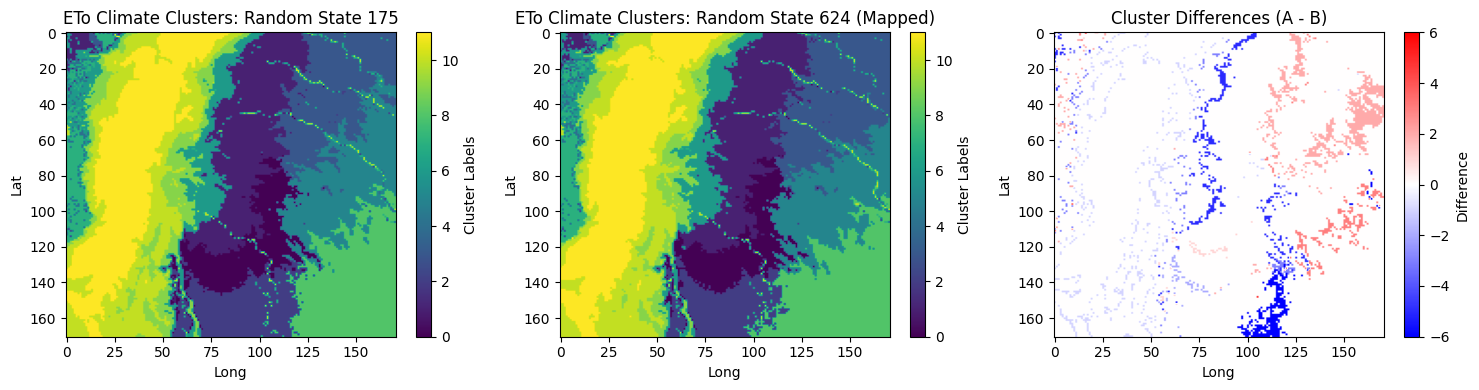

In [ ]:
from scipy.optimize import linear_sum_assignment

random_state_A =  np.random.randint(1, 1000)
random_state_B =  np.random.randint(1, 1000)
print("random_state_A", random_state_A)
print("random_state_B", random_state_B)

m_  = 3
n_  = 4
lr_ = 0.29
max_iter_ = 8e5

# Training the SOM with random state A.
som_model_random_state_A = CustomSOM(m=m_, n=n_, dim=38, lr=lr_, max_iter=max_iter_, random_state=random_state_A)
som_model_random_state_A.fit(ETo_climate_SOM_input_signal_train_normalized)
# Testing the SOM with random state A.
centroids_random_state_A = som_model_random_state_A.transform(ETo_climate_SOM_input_signal_validation_normalized)
# Reorder the position of the ETo climate classes with random state A.
centroids_mean_random_state_A = np.sum(centroids_random_state_A, axis=0)
centroids_reorder_random_state_A = centroids_random_state_A[:, np.argsort(centroids_mean_random_state_A)]
labels_random_state_A = np.argmin(centroids_reorder_random_state_A, axis=1)

# Training the SOM with random state B.
som_model_random_state_B = CustomSOM(m=m_, n=n_, dim=38, lr=lr_, max_iter=max_iter_, random_state=random_state_B)
som_model_random_state_B.fit(ETo_climate_SOM_input_signal_train_normalized)
# Testing the SOM with random state B.
centroids_random_state_B = som_model_random_state_B.transform(ETo_climate_SOM_input_signal_validation_normalized)
# Reorder the position of the ETo climate classes with random state B.
centroids_mean_random_state_B = np.sum(centroids_random_state_B, axis=0)
centroids_reorder_random_state_B = centroids_random_state_B[:, np.argsort(centroids_mean_random_state_B)]
labels_random_state_B = np.argmin(centroids_reorder_random_state_B, axis=1)

# Calculate the cost matrix where each element is the sum of squared differences between centroids.
cost_matrix = np.zeros((m_ * n_, m_ * n_))
for i in range(m_ * n_):
    for j in range(m_ * n_):
        cost_matrix[i, j] = np.sum((centroids_reorder_random_state_A[:, i] - centroids_reorder_random_state_B[:, j]) ** 2)

# Use the Hungarian algorithm to find the optimal assignment.
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Map labels according to the optimal assignment.
mapped_labels_B = np.zeros_like(labels_random_state_B)
for i, j in zip(row_ind, col_ind):
    mapped_labels_B[labels_random_state_B == j] = i

# Calculate the difference between mapped labels.
ETo_climate_diff = labels_random_state_A - mapped_labels_B

# Create DataFrames for plotting.
ETo_climate_pd_random_state_A = ETo_climate_SOM_input_signal_validation_pd.copy()
ETo_climate_pd_random_state_A['ETo_climate_clusters'] = labels_random_state_A
ETo_climate_pd_random_state_B = ETo_climate_SOM_input_signal_validation_pd.copy()
ETo_climate_pd_random_state_B['ETo_climate_clusters'] = mapped_labels_B

# Combine the two datasets for easier plotting.
pivot_A = ETo_climate_pd_random_state_A.pivot_table(index='pixel_y', columns='pixel_x', values='ETo_climate_clusters')
pivot_B = ETo_climate_pd_random_state_B.pivot_table(index='pixel_y', columns='pixel_x', values='ETo_climate_clusters')

# Calculate percentage of non-zero pixels in the difference matrix.
total_pixels = len(ETo_climate_diff)
non_zero_pixels = np.count_nonzero(ETo_climate_diff)
percent_non_zero = (non_zero_pixels / total_pixels) * 100

print(f"Percentage of different pixels: {percent_non_zero:.2f}%")

# Pivot for the difference plot.
ETo_climate_pd_diff = ETo_climate_SOM_input_signal_validation_normalized_pd.copy()
ETo_climate_pd_diff['Cluster_Difference'] = ETo_climate_diff
pivot_diff = ETo_climate_pd_diff.pivot_table(index='pixel_y', columns='pixel_x', values='Cluster_Difference')

# Set up the figure and subplots (1 row, 3 columns).
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot for Random State A.
im_A = axes[0].imshow(pivot_A, cmap='viridis', aspect='auto', vmin=0, vmax=11)
axes[0].set_title(f'ETo Climate Clusters: Random State {random_state_A}')
axes[0].set_xlabel('Long')
axes[0].set_ylabel('Lat')
fig.colorbar(im_A, ax=axes[0], label="Cluster Labels")

# Plot for Random State B.
im_B = axes[1].imshow(pivot_B, cmap='viridis', aspect='auto', vmin=0, vmax=11)
axes[1].set_title(f'ETo Climate Clusters: Random State {random_state_B} (Mapped)')
axes[1].set_xlabel('Long')
axes[1].set_ylabel('Lat')
fig.colorbar(im_B, ax=axes[1], label="Cluster Labels")

# Plot for Difference (Random State A - Mapped Random State B).
im_diff = axes[2].imshow(pivot_diff, cmap='bwr', aspect='auto', vmin=-np.max(np.abs(ETo_climate_diff)), vmax=np.max(np.abs(ETo_climate_diff)))
axes[2].set_title("Cluster Differences (A - B)")
axes[2].set_xlabel('Long')
axes[2].set_ylabel('Lat')
fig.colorbar(im_diff, ax=axes[2], label="Difference")

# Adjust layout and show the plot.
plt.tight_layout()
plt.show()

## 1.8 Number of clusters determination

In [ ]:
# Function to evaluate ETo climate SOM hyperparmeters in function of repeatability.
def evaluate_som_hyperparameters(m=3, n=4, lr=None, max_iter=None, data_train=None, data_validation=None):
    random_state_A = np.random.randint(1, 1000)
    random_state_B = np.random.randint(1, 1000)

    # Initialize and train SOM for random state A.
    som_model_random_state_A = CustomSOM(m=m, n=n, dim=38, lr=lr, max_iter=max_iter, random_state=random_state_A)
    som_model_random_state_A.fit(data_train)

    # Testing the SOM with random state A.
    centroids_random_state_A = som_model_random_state_A.transform(data_validation)
    centroids_mean_random_state_A = np.sum(centroids_random_state_A, axis=0)
    centroids_reorder_random_state_A = centroids_random_state_A[:, np.argsort(centroids_mean_random_state_A)]
    labels_random_state_A = np.argmin(centroids_reorder_random_state_A, axis=1)

    # Initialize and train SOM for random state B
    som_model_random_state_B = CustomSOM(m=m, n=n, dim=38, lr=lr, max_iter=max_iter, random_state=random_state_B)
    som_model_random_state_B.fit(data_train)

    # Testing the SOM with random state B
    centroids_random_state_B = som_model_random_state_B.transform(data_validation)
    centroids_mean_random_state_B = np.sum(centroids_random_state_B, axis=0)
    centroids_reorder_random_state_B = centroids_random_state_B[:, np.argsort(centroids_mean_random_state_B)]
    labels_random_state_B = np.argmin(centroids_reorder_random_state_B, axis=1)

    # Calculate cost matrix and find optimal assignment using Hungarian algorithm.
    cost_matrix = np.zeros((m * n, m * n))
    for i in range(m * n):
        for j in range(m * n):
            cost_matrix[i, j] = np.sum((centroids_reorder_random_state_A[:, i] - centroids_reorder_random_state_B[:, j]) ** 2)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Map labels according to the optimal assignment.
    mapped_labels_B = np.zeros_like(labels_random_state_B)
    for i, j in zip(row_ind, col_ind):
        mapped_labels_B[labels_random_state_B == j] = i

    # Calculate the difference between mapped labels.
    ETo_climate_diff = labels_random_state_A - mapped_labels_B
    total_pixels     = len(ETo_climate_diff)
    non_zero_pixels  = np.count_nonzero(ETo_climate_diff)
    percent_non_zero = (non_zero_pixels / total_pixels) * 100

    return percent_non_zero

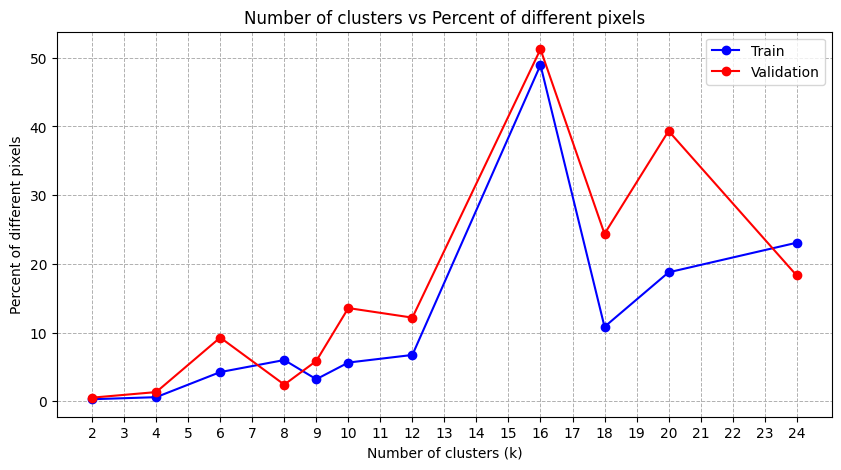

In [ ]:
# Specific values for m and n.
m_values            = [1, 2, 2, 4, 3,  2,  3,  4,  3,  4,  4]
n_values            = [2, 2, 3, 2, 3,  5,  4,  4,  6,  5,  6]
k_values            = [2, 4, 6, 8, 9, 10, 12, 16, 18, 20, 24]
results_train       = []
results_validation  = []
lr                  = 0.3
max_iter            = 1e9

for i in range(len(k_values)):
    percent_non_zero = evaluate_som_hyperparameters(m_values[i], n_values[i], lr=lr, max_iter=max_iter,
                                                    data_train      =ETo_climate_SOM_input_signal_train_normalized,
                                                    data_validation =ETo_climate_SOM_input_signal_train_normalized)
    results_train.append((percent_non_zero))

for i in range(len(k_values)):
    percent_non_zero = evaluate_som_hyperparameters(m_values[i], n_values[i], lr=lr, max_iter=max_iter,
                                                    data_train      =ETo_climate_SOM_input_signal_train_normalized,
                                                    data_validation =ETo_climate_SOM_input_signal_validation_normalized)
    results_validation.append((percent_non_zero))

# Plot the distortion in terms of "k".
plt.figure(figsize=(10, 5))
plt.plot(k_values, results_train, marker='o', linestyle='-', color='b', label='Train')
plt.plot(k_values, results_validation, marker='o', linestyle='-', color='r', label='Validation')
plt.xticks(range(2, 25))
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Percent of different pixels')
plt.title('Number of clusters vs Percent of different pixels')
plt.legend()
plt.savefig("ETo_climate_k_selection.png", dpi=300, bbox_inches='tight')
plt.show()

## 1.9. Maximum number of iterations determination

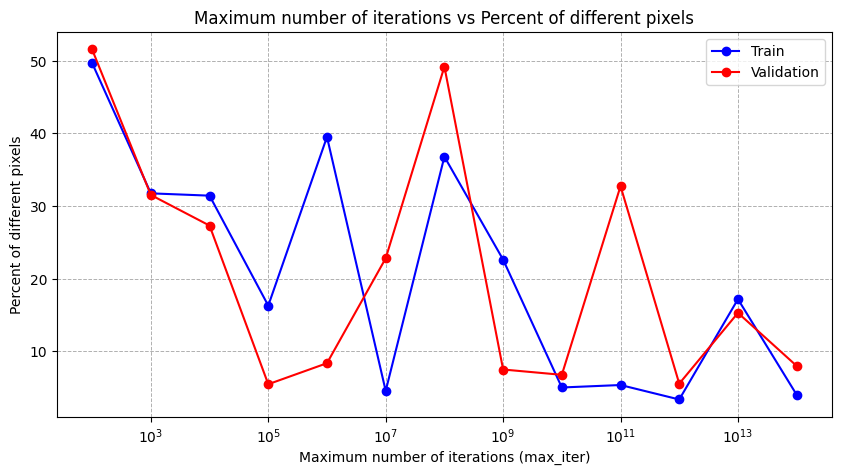

In [ ]:
from joblib import Parallel, delayed

# Specific values for max_iter.
max_iter_values     = [100, 1000, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12, 1e13, 1e14]
results_train       = []
results_validation  = []
lr                  = 0.3

for i in range(len(max_iter_values)):
    percent_non_zero = evaluate_som_hyperparameters(m=3, n=4, lr=0.3, max_iter=max_iter_values[i],
                                                    data_train      =ETo_climate_SOM_input_signal_train_normalized,
                                                    data_validation =ETo_climate_SOM_input_signal_train_normalized)
    results_train.append((percent_non_zero))

for i in range(len(max_iter_values)):
    percent_non_zero = evaluate_som_hyperparameters(m=3, n=4, lr=0.3, max_iter=max_iter_values[i],
                                                    data_train      =ETo_climate_SOM_input_signal_train_normalized,
                                                    data_validation =ETo_climate_SOM_input_signal_validation_normalized)
    results_validation.append((percent_non_zero))

# Plot the distortion in terms of "max_iter".
plt.figure(figsize=(10, 5))
plt.plot(max_iter_values, results_train, marker='o', linestyle='-', color='b', label='Train')
plt.plot(max_iter_values, results_validation, marker='o', linestyle='-', color='r', label='Validation')
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.xlabel('Maximum number of iterations (max_iter)')
plt.ylabel('Percent of different pixels')
plt.title('Maximum number of iterations vs Percent of different pixels')
plt.xscale('log')
plt.legend()
plt.savefig("ETo_climate_max_iter_selection.png", dpi=300, bbox_inches='tight')
plt.show()

## 1.10. Learning rate determination

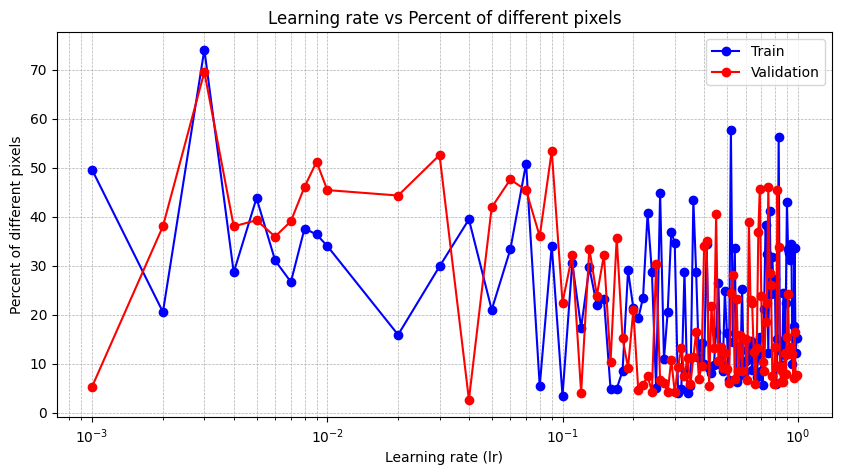

In [ ]:
# Specific values for learning rate.
lr_values          = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
                       0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
                       0.10,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,  0.19,
                       0.20,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0.27,  0.28,  0.29,
                       0.30,  0.31,  0.32,  0.33,  0.34,  0.35,  0.36,  0.37,  0.38,  0.39,
                       0.40,  0.41,  0.42,  0.43,  0.44,  0.45,  0.46,  0.47,  0.48,  0.49,
                       0.50,  0.51,  0.52,  0.53,  0.54,  0.55,  0.56,  0.57,  0.58,  0.59,
                       0.60,  0.61,  0.62,  0.63,  0.64,  0.65,  0.66,  0.67,  0.68,  0.69,
                       0.70,  0.71,  0.72,  0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,
                       0.80,  0.81,  0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,
                       0.90,  0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,  0.99,]
results_train      = []
results_validation = []
max_iter           = 1e9

for i in range(len(lr_values)):
    percent_non_zero = evaluate_som_hyperparameters(m=3, n=4, lr=lr_values[i], max_iter=max_iter,
                                                    data_train      =ETo_climate_SOM_input_signal_train_normalized,
                                                    data_validation =ETo_climate_SOM_input_signal_train_normalized)
    results_train.append((percent_non_zero))

for i in range(len(lr_values)):
    percent_non_zero = evaluate_som_hyperparameters(m=3, n=4, lr=lr_values[i], max_iter=max_iter,
                                                    data_train      =ETo_climate_SOM_input_signal_train_normalized,
                                                    data_validation =ETo_climate_SOM_input_signal_validation_normalized)
    results_validation.append((percent_non_zero))

# Plot the distortion in terms of "lr".
plt.figure(figsize=(10, 5))
plt.plot(lr_values, results_train, marker='o', linestyle='-', color='b', label='Train')
plt.plot(lr_values, results_validation, marker='o', linestyle='-', color='r', label='Validation')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Learning rate (lr)')
plt.ylabel('Percent of different pixels')
plt.title('Learning rate vs Percent of different pixels')
plt.xscale('log')
plt.legend()
plt.savefig("ETo_climate_lr_opt.png", dpi=300, bbox_inches='tight')
plt.show()

## 2. Evaluation of Trained and Tested Datasets in Terms of Repeatibility

random_state_A 46
random_state_B 13
Percentage of different pixels: 4.90%


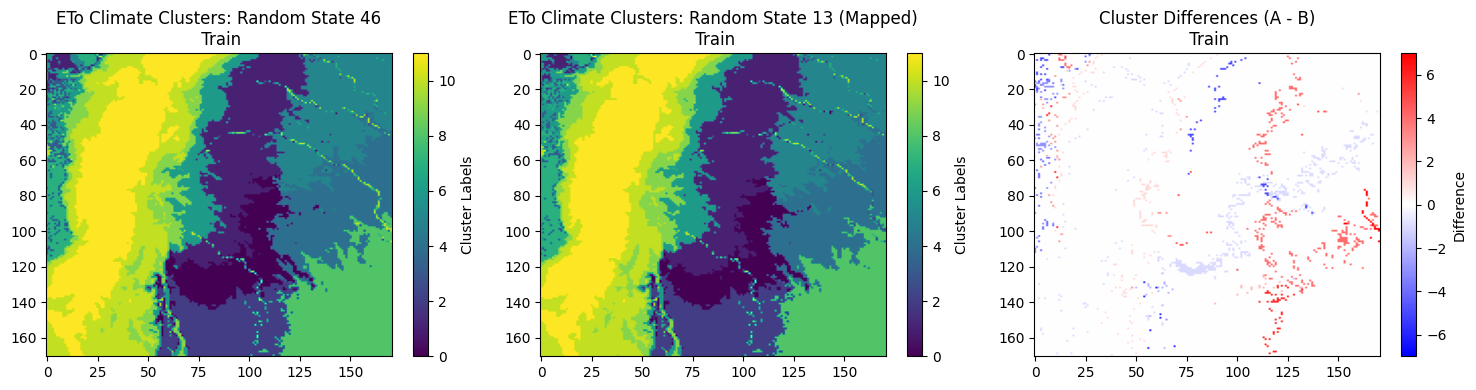

Percentage of different pixels: 5.34%


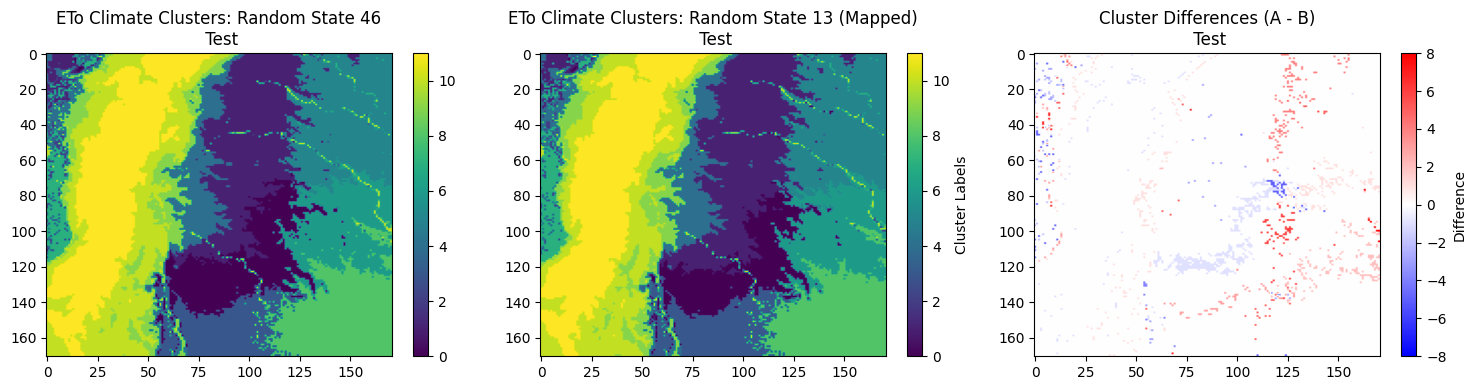

In [ ]:
from scipy.optimize import linear_sum_assignment

random_state_A =  np.random.randint(1, 1000)
random_state_B =  np.random.randint(1, 1000)
print("random_state_A", random_state_A)
print("random_state_B", random_state_B)

m_  = 3
n_  = 4
lr_ = 0.25
max_iter_ = 9e8

# TRAIN

# Training the SOM with random state A
som_model_random_state_A = CustomSOM(m=m_, n=n_, dim=38, lr=lr_, max_iter=max_iter_, random_state=random_state_A)
som_model_random_state_A.fit(ETo_climate_SOM_input_signal_train_normalized)
# Testing the SOM with random state A
centroids_random_state_A = som_model_random_state_A.transform(ETo_climate_SOM_input_signal_validation_normalized)
# Reorder the position of the ETo climate classes with random state A
centroids_mean_random_state_A = np.sum(centroids_random_state_A, axis=0)
centroids_reorder_random_state_A = centroids_random_state_A[:, np.argsort(centroids_mean_random_state_A)]
labels_random_state_A = np.argmin(centroids_reorder_random_state_A, axis=1)

# Training the SOM with random state B
som_model_random_state_B = CustomSOM(m=m_, n=n_, dim=38, lr=lr_, max_iter=max_iter_, random_state=random_state_B)
som_model_random_state_B.fit(ETo_climate_SOM_input_signal_train_normalized)
# Testing the SOM with random state B
centroids_random_state_B = som_model_random_state_B.transform(ETo_climate_SOM_input_signal_validation_normalized)
# Reorder the position of the ETo climate classes with random state B
centroids_mean_random_state_B = np.sum(centroids_random_state_B, axis=0)
centroids_reorder_random_state_B = centroids_random_state_B[:, np.argsort(centroids_mean_random_state_B)]
labels_random_state_B = np.argmin(centroids_reorder_random_state_B, axis=1)

# Calculate the cost matrix where each element is the sum of squared differences between centroids
cost_matrix = np.zeros((m_ * n_, m_ * n_))
for i in range(m_ * n_):
    for j in range(m_ * n_):
        cost_matrix[i, j] = np.sum((centroids_reorder_random_state_A[:, i] - centroids_reorder_random_state_B[:, j]) ** 2)

# Use the Hungarian algorithm to find the optimal assignment
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Map labels according to the optimal assignment
mapped_labels_B = np.zeros_like(labels_random_state_B)
for i, j in zip(row_ind, col_ind):
    mapped_labels_B[labels_random_state_B == j] = i

# Calculate the difference between mapped labels
ETo_climate_diff = labels_random_state_A - mapped_labels_B

# Create DataFrames for plotting
ETo_climate_pd_random_state_A = ETo_climate_SOM_input_signal_validation_pd.copy()
ETo_climate_pd_random_state_A['ETo_climate_clusters'] = labels_random_state_A
ETo_climate_pd_random_state_B = ETo_climate_SOM_input_signal_validation_pd.copy()
ETo_climate_pd_random_state_B['ETo_climate_clusters'] = mapped_labels_B

# Combine the two datasets for easier plotting
pivot_A = ETo_climate_pd_random_state_A.pivot_table(index='pixel_y', columns='pixel_x', values='ETo_climate_clusters')
pivot_B = ETo_climate_pd_random_state_B.pivot_table(index='pixel_y', columns='pixel_x', values='ETo_climate_clusters')

# Calculate percentage of non-zero pixels in the difference matrix
total_pixels = len(ETo_climate_diff)
non_zero_pixels = np.count_nonzero(ETo_climate_diff)
percent_non_zero = (non_zero_pixels / total_pixels) * 100

print(f"Percentage of different pixels in Train: {percent_non_zero:.2f}%")

# Pivot for the difference plot
ETo_climate_pd_diff = ETo_climate_SOM_input_signal_validation_normalized_pd.copy()
ETo_climate_pd_diff['Cluster_Difference'] = ETo_climate_diff
pivot_diff = ETo_climate_pd_diff.pivot_table(index='pixel_y', columns='pixel_x', values='Cluster_Difference')

# Set up the figure and subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot for Random State A
im_A = axes[0].imshow(pivot_A, cmap='viridis', aspect='auto', vmin=0, vmax=11)
axes[0].set_title(f'ETo Climate Clusters: Random State {random_state_A}\n Train')
#axes[0].set_xlabel('Long')
#axes[0].set_ylabel('Lat')
fig.colorbar(im_A, ax=axes[0], label="Cluster Labels")

# Plot for Random State B
im_B = axes[1].imshow(pivot_B, cmap='viridis', aspect='auto', vmin=0, vmax=11)
axes[1].set_title(f'ETo Climate Clusters: Random State {random_state_B} (Mapped)\n Train')
#axes[1].set_xlabel('Long')
#axes[1].set_ylabel('Lat')
fig.colorbar(im_B, ax=axes[1], label="Cluster Labels")

# Plot for Difference (Random State A - Mapped Random State B)
im_diff = axes[2].imshow(pivot_diff, cmap='bwr', aspect='auto', vmin=-np.max(np.abs(ETo_climate_diff)), vmax=np.max(np.abs(ETo_climate_diff)))
axes[2].set_title("Cluster Differences (A - B)\n Train")
#axes[2].set_xlabel('Long')
#axes[2].set_ylabel('Lat')
fig.colorbar(im_diff, ax=axes[2], label="Difference")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# TEST

# Evaluating random state A with test data:
centroids_random_state_A = som_model_random_state_A.transform(ETo_climate_SOM_input_signal_test_normalized)
centroids_mean_random_state_A = np.sum(centroids_random_state_A, axis=0)
centroids_reorder_random_state_A = centroids_random_state_A[:, np.argsort(centroids_mean_random_state_A)]
labels_random_state_A = np.argmin(centroids_reorder_random_state_A, axis=1)

# Evaluating random state B with test data:
centroids_random_state_B = som_model_random_state_B.transform(ETo_climate_SOM_input_signal_test_normalized)
centroids_mean_random_state_B = np.sum(centroids_random_state_B, axis=0)
centroids_reorder_random_state_B = centroids_random_state_B[:, np.argsort(centroids_mean_random_state_B)]
labels_random_state_B = np.argmin(centroids_reorder_random_state_B, axis=1)

# Calculate the cost matrix where each element is the sum of squared differences between centroids
cost_matrix = np.zeros((m_ * n_, m_ * n_))
for i in range(m_ * n_):
    for j in range(m_ * n_):
        cost_matrix[i, j] = np.sum((centroids_reorder_random_state_A[:, i] - centroids_reorder_random_state_B[:, j]) ** 2)

# Use the Hungarian algorithm to find the optimal assignment
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Map labels according to the optimal assignment
mapped_labels_B = np.zeros_like(labels_random_state_B)
for i, j in zip(row_ind, col_ind):
    mapped_labels_B[labels_random_state_B == j] = i

# Calculate the difference between mapped labels
ETo_climate_diff = labels_random_state_A - mapped_labels_B

# Create DataFrames for plotting
ETo_climate_pd_random_state_A = ETo_climate_SOM_input_signal_test_pd.copy()
ETo_climate_pd_random_state_A['ETo_climate_clusters'] = labels_random_state_A
ETo_climate_pd_random_state_B = ETo_climate_SOM_input_signal_test_pd.copy()
ETo_climate_pd_random_state_B['ETo_climate_clusters'] = mapped_labels_B

# Combine the two datasets for easier plotting
pivot_A = ETo_climate_pd_random_state_A.pivot_table(index='pixel_y', columns='pixel_x', values='ETo_climate_clusters')
pivot_B = ETo_climate_pd_random_state_B.pivot_table(index='pixel_y', columns='pixel_x', values='ETo_climate_clusters')

# Calculate percentage of non-zero pixels in the difference matrix
total_pixels = len(ETo_climate_diff)
non_zero_pixels = np.count_nonzero(ETo_climate_diff)
percent_non_zero = (non_zero_pixels / total_pixels) * 100

print(f"Percentage of different pixels in Test: {percent_non_zero:.2f}%")

# Pivot for the difference plot
ETo_climate_pd_diff = ETo_climate_SOM_input_signal_test_pd.copy()
ETo_climate_pd_diff['Cluster_Difference'] = ETo_climate_diff
pivot_diff = ETo_climate_pd_diff.pivot_table(index='pixel_y', columns='pixel_x', values='Cluster_Difference')

# Set up the figure and subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot for Random State A
im_A = axes[0].imshow(pivot_A, cmap='viridis', aspect='auto')
axes[0].set_title(f'ETo Climate Clusters: Random State {random_state_A}\n Test')
fig.colorbar(im_A, ax=axes[0], label="Cluster Labels")

# Plot for Random State B
im_B = axes[1].imshow(pivot_B, cmap='viridis', aspect='auto')
axes[1].set_title(f'ETo Climate Clusters: Random State {random_state_B} (Mapped)\n Test')
fig.colorbar(im_B, ax=axes[1], label="Cluster Labels")

# Plot for Difference (Random State A - Mapped Random State B)
im_diff = axes[2].imshow(
    pivot_diff, cmap='bwr', aspect='auto',
    vmin=-np.max(np.abs(ETo_climate_diff)), vmax=np.max(np.abs(ETo_climate_diff))
)
axes[2].set_title("Cluster Differences (A - B)\n Test")
fig.colorbar(im_diff, ax=axes[2], label="Difference")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()